In [7]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json
import pandas as pd

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
# from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op
from pyhf_pymc import plotting

In [2]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

In [2]:
blue = '#1F449C'
orange = '#E57A77'

plt.rc('font', size=18)      
plt.rc('axes', titlesize=18)   
plt.rc('axes', labelsize=18)   
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18)    
plt.rc('legend', fontsize=15)    
plt.rc('figure', titlesize=18)

## Model

In [3]:
nBins = 3
model = pyhf.simplemodels.correlated_background([10,15,20],[50,40,30],[55, 45, 35],[45, 35, 25])

unconstr_priors = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}

data = [60, 55, 50]
truth = [0., 1.]

# prior_dict = prepare_inference.prepare_priors(model, unconstr_priors)
# prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

expData_op = make_op.make_op(model)

In [4]:
with infer.model(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=10_000, chains=1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


### Prior and Posterior Predictives

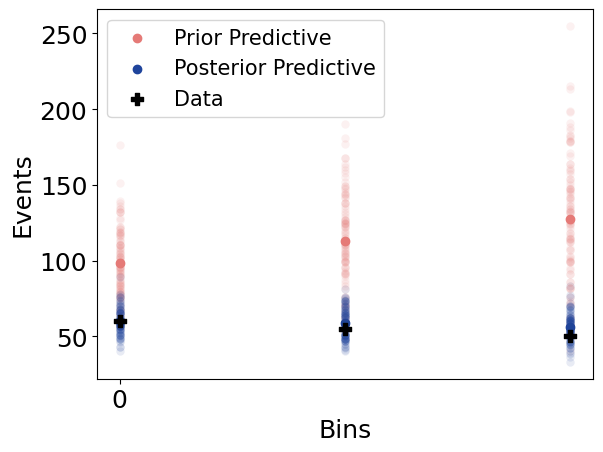

In [7]:
plotting.prior_posterior_predictives(model=model, observed=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=3)

### Corner Plots

In [18]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(10_000, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


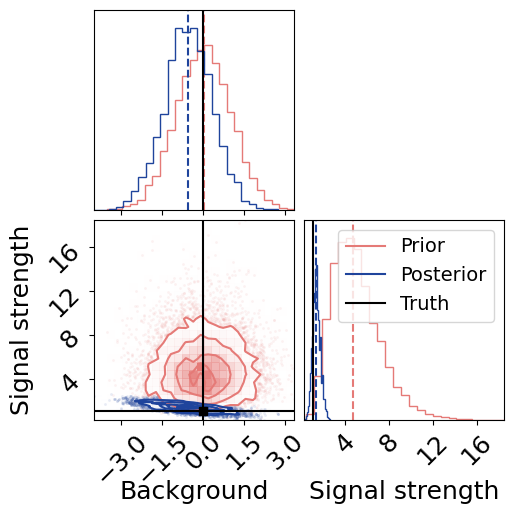

In [31]:
my_bins = [25, 25]
import matplotlib.lines as mlines

a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, title_fmt=None, color=orange, labels=['', ''], bins=my_bins)
corner.corner(post_data.posterior, quantiles=[0.5], color = blue, truths=[0., 1.], truth_color='black', bins=[25, 25], fig=a, labels=['Background', 'Signal strength'])
plt.legend(handles=[
            (mlines.Line2D([], [], color=orange, label='Prior')),
            (mlines.Line2D([], [], color=blue, label='Posterior')),
            (mlines.Line2D([], [], color='black', label='Truth'))
            
        ], loc="upper right", fontsize=14)
# a.suptitle('Prior and Posterior Parameter Distributions')

array([[<AxesSubplot: title={'center': 'Normals'}>,
        <AxesSubplot: title={'center': 'Normals'}>],
       [<AxesSubplot: title={'center': 'Unconstrained'}>,
        <AxesSubplot: title={'center': 'Unconstrained'}>]], dtype=object)

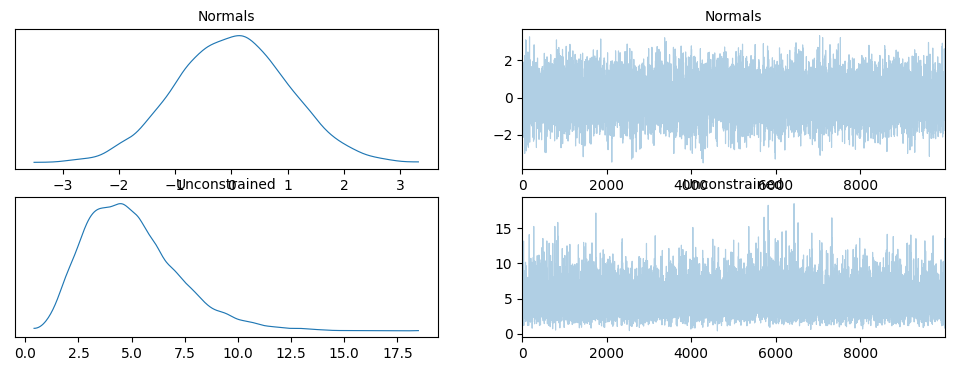

In [33]:
az.plot_trace(prior_pred.prior)

### Calibration

In [ ]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    prior_pred = pm.sample_prior_predictive(10)

prior_Normals, prior_Unconstrained, prior_data = np.concatenate(prior_pred.prior.Normals[0]), np.concatenate(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

# with open('prior_Normals_Metropolis.txt', 'w') as filehandle:
#     json.dump(prior_Normals.tolist(), filehandle)
# with open('prior_Unconstrained_Metropolis.txt', 'w') as filehandle:
#     json.dump(prior_Unconstrained.tolist(), filehandle)

In [ ]:
# post_Normals, post_Unconstrained, post_data = plotting.calibration(prepared_model, prior_pred)
# with open('post_Normals_Metropolis.txt', 'w') as filehandle:
#     json.dump(post_Normals.tolist(), filehandle)
# with open('post_Unconstrained_Metropolis.txt', 'w') as filehandle:
#     json.dump(post_Unconstrained.tolist(), filehandle)


post_Normals, post_Unconstrained, post_data = [], [], []
i = 0
for p_d in prior_data:
    a, b, c = posterior_from_prior(p_d)
    post_Normals.append(a[0])
    post_Unconstrained.append(b[0])
    post_data.append(c[0])

    with open('post_Normals_Metropolis.txt', 'a') as file:
        file.write(f'{post_Normals[i]}, ')

    with open('post_Unconstrained_Metropolis.txt', 'a') as file:
        file.write(f'{post_Unconstrained[i]}, ')

    print(f'STEP: {i}')
    i += 1

In [36]:
prior_Normals = np.array(pd.read_csv('prior_Normals_Metropolis.txt', header=None))[0]
prior_Unconstrained = np.array(pd.read_csv('prior_Unconstrained_Metropolis.txt', header=None))[0]

post_Normals = np.array(pd.read_csv('post_Normals_Metropolis.txt', header=None))[0].tolist()
post_Normals.remove(' ')
post_Unconstrained = np.array(pd.read_csv('post_Unconstrained_Metropolis.txt', header=None))[0].tolist()
post_Unconstrained.remove(' ')

In [37]:
prior_Normals

array([-1.72174903, -0.20226815, -0.79200699, ...,  1.01486211,
        0.894938  ,  0.41538271])

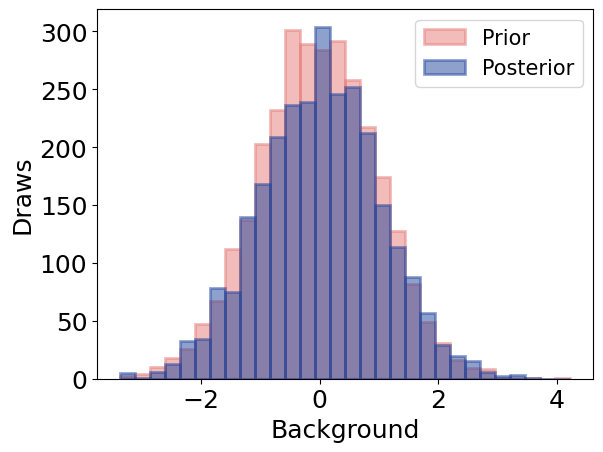

In [49]:
# Plot Normals
plt.hist(prior_Normals, 30, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Normals, bins=30, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Normals, bins = bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Background')
plt.ylabel('Draws')

plt.legend()


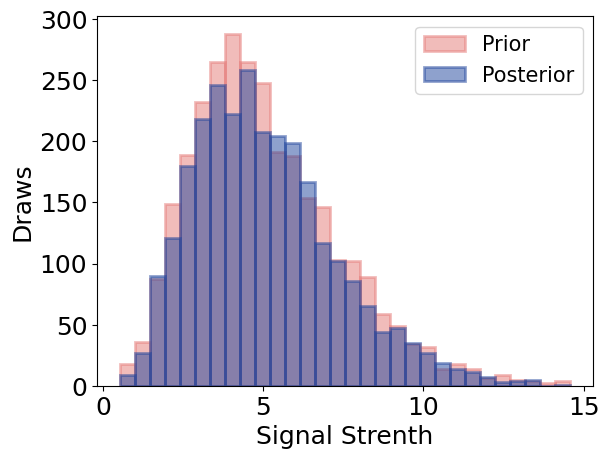

In [48]:
# Plot Unconstrained 
plt.hist(prior_Unconstrained, 30, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Unconstrained, bins=30, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Unconstrained, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Signal Strenth')
plt.ylabel('Draws')

plt.legend()

plt.show()